# Section 1: Business Understanding

# Stack Overflow's 2020 survey analysis of programming languages

### This notebook is an analysis of Stack Overflow's Survey aiming to answer questions about choices of main programming language and their impact on the developers

#### Medium Post https://gabrieldiasdeabreu.medium.com/dont-choose-your-main-programming-language-before-reading-this-5b416c93b9ac

### Question 1: Programming Language impacts on the Job Satisfaction?
### Question 2: Which languages pay the biggest salaries and have more developers?
### Question 3: How much are developers working with some language engaged in online communities?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Section 2: Data Understanding


## Gather dataset

In [2]:
df_stack_overflow_survey = pd.read_csv('survey_results_public.csv')
df_stack_overflow_survey_features_descriptions = pd.read_csv('survey_results_schema.csv')

## Dataset columns and description

In [3]:
for x in df_stack_overflow_survey_features_descriptions.values:
    print(x[0], '->', x[1])

Respondent -> Randomized respondent ID number (not in order of survey response time)
MainBranch -> Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."
Hobbyist -> Do you code as a hobby?
Age -> What is your age (in years)? If you prefer not to answer, you may leave this question blank.
Age1stCode -> At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)
CompFreq -> Is that compensation weekly, monthly, or yearly?
CompTotal -> What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty.
ConvertedComp -> Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working mon

## How many answers are in the 2020 Survey?

In [4]:
df_stack_overflow_survey['Respondent'].count()

64461

## Wich languages are avaible?

In [5]:
all_languages = set(';'.join(list(df_stack_overflow_survey['LanguageWorkedWith'].dropna())).split(';'))
all_languages

{'Assembly',
 'Bash/Shell/PowerShell',
 'C',
 'C#',
 'C++',
 'Dart',
 'Go',
 'HTML/CSS',
 'Haskell',
 'Java',
 'JavaScript',
 'Julia',
 'Kotlin',
 'Objective-C',
 'PHP',
 'Perl',
 'Python',
 'R',
 'Ruby',
 'Rust',
 'SQL',
 'Scala',
 'Swift',
 'TypeScript',
 'VBA'}

## How many answers by programming language?

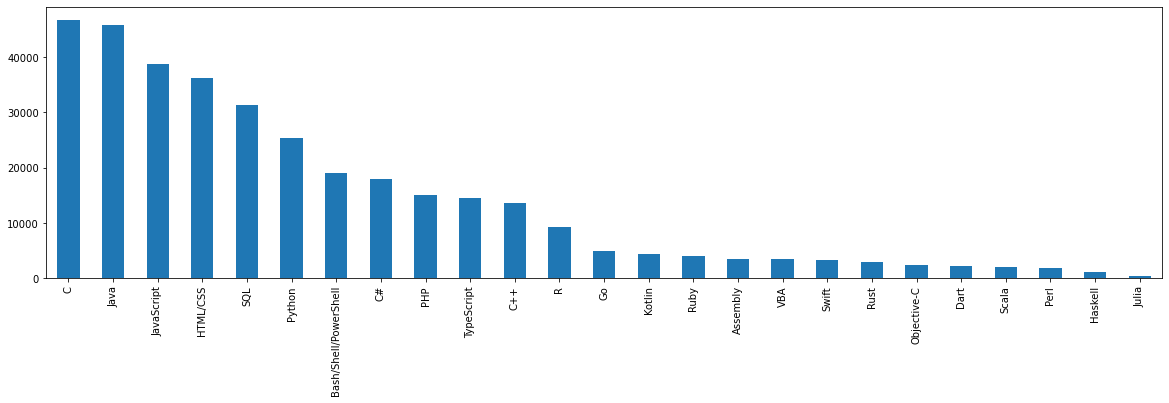

In [6]:
count_by_language = {language: np.sum(df_stack_overflow_survey['LanguageWorkedWith'].str.contains(language.replace('+', '\+'))) for language in all_languages}
pd.DataFrame(count_by_language,  index=['count']).T \
    .sort_values(by='count', ascending=False) \
    .plot.bar(figsize=[20,5], legend=False);

We can see there are more developers working with C, Java, and JavaScript. Number of developers working with Go, kotlin, Ruby, and so on is less than 1/4 of those most popular languages.

## Job Satisfaction is an scale from Very Satisfied to Very Dissatisfied 

In [7]:
set(df_stack_overflow_survey['JobSat'])

{'Neither satisfied nor dissatisfied',
 'Slightly dissatisfied',
 'Slightly satisfied',
 'Very dissatisfied',
 'Very satisfied',
 nan}

# Section 3: Data Preparation

In [8]:
def create_column_for_each_language(df):    
    """
    Receive a dataframe df with LanguageWorkedWith column and append a column for each 
    language with a True if it is present in the answer or False if it is nan or not present in 
    This new column works as an mask 
    """
    for language in all_languages:
        df.loc[:, language] = df['LanguageWorkedWith'].apply(lambda answer: language in answer if pd.notnull(answer) else False)
create_column_for_each_language(df_stack_overflow_survey)

In [16]:
def create_df_with_number_of_active_members_communities(df):
    """
    Create a dataframe with percentage of satisfaction by each programming language ordered by job satisfaction scale
    """
    satisfaction_order = ['Very satisfied', 'Slightly satisfied', 'Neither satisfied nor dissatisfied', 'Slightly dissatisfied', 'Very dissatisfied']

    count_satistaction_by_language = list()
    for language in all_languages:
        count_per_group = df_stack_overflow_survey[(df_stack_overflow_survey[language])].groupby('JobSat').count()['Respondent']
        count_respondents_per_language = df_stack_overflow_survey[(df_stack_overflow_survey[language])].groupby('JobSat').count()['Respondent'].sum()
        count_satistaction_by_language.append(count_per_group / count_respondents_per_language)

    df_count_satistaction_by_language = pd.DataFrame(count_satistaction_by_language, index=all_languages)[satisfaction_order]
    return df_count_satistaction_by_language.sort_values(by=satisfaction_order, ascending=False, axis=0)
df_count_satistaction_by_language = create_df_with_number_of_active_members_communities(df_stack_overflow_survey)

In [10]:
def create_df_with_count_of_developers_and_median_salary(df):
    """
    receives an df and returns another df with median amount of salary and number of respondents
    """
    count_amount_by_Language = list()
    for language in all_languages:
        by_language = df[df[language]]['ConvertedComp']
        count_amount_by_Language.append(by_language)

    df_count_amount_by_Language = pd.DataFrame(count_amount_by_Language, index=all_languages)

    return pd.concat([
        df_count_amount_by_Language.T.median(), 
        df_count_amount_by_Language.T.count()
        ], axis=1, keys=['amount', 'count'])


df_median_amount_count = create_df_with_count_of_developers_and_median_salary(df_stack_overflow_survey)

In [11]:
def create_df_with_number_of_active_members_communities(df):
    """
    count number of communities active developers by programming language and returns a dataframe
    """
    amount_community_active = list()
    for language in all_languages:
        amount_community_active.append(df[(df['NEWOtherComms'] == 'Yes') & (df[language])]['Respondent'].count())

    return pd.DataFrame(amount_community_active, index=all_languages, columns=['count']).sort_values(by='count', ascending=False)

df_amount_community_active = create_df_with_number_of_active_members_communities(df_stack_overflow_survey)


# Section 4: Evaluate the Results

## Programming Language impacts on the Job Satisfaction?

Plot this dataframe as an ordered heatmap. Heatmap is a good way to see categorical data with an quantitative dimension given by percentage of respondents. It ables us to compare satisfaction among languages quickly.

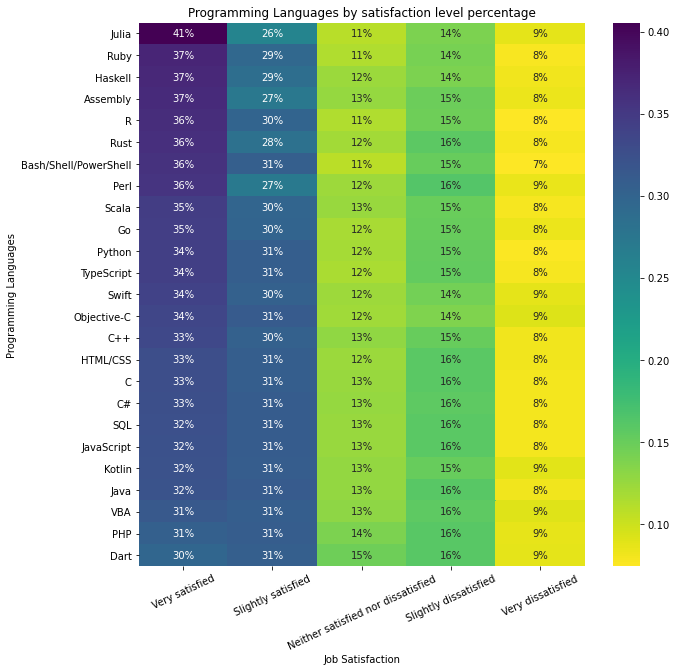

In [12]:
plt.figure(figsize=[10, 10])
sb.heatmap(df_count_satistaction_by_language,
           cmap='viridis_r', annot=True, fmt='.0%');
plt.xticks(rotation=25);
plt.xlabel('Job Satisfaction')
plt.ylabel('Programming Languages');
plt.title("Programming Languages by satisfaction level percentage");

This chart shows an 11% difference between the biggest very satisfied rate and lowest very satisfied rate that indicates the language you choose impacts on your job satisfaction

# Which languages pay the biggest salaries and have more developers?

Plot a scatter plot salary x number of developers and
move dots to avoid stacked labels

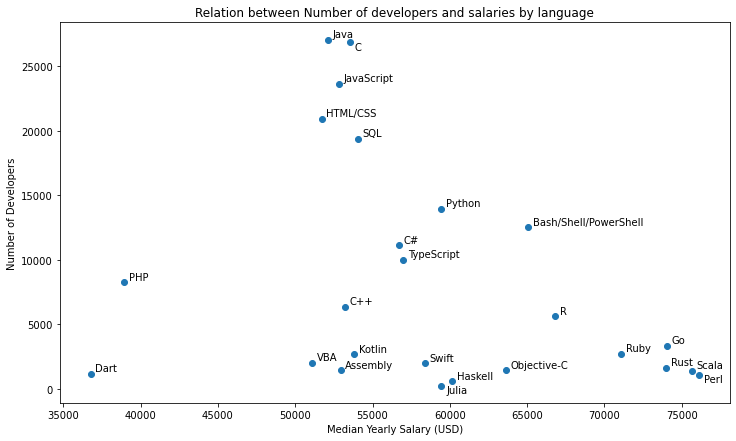

In [13]:
fig, ax = plt.subplots(figsize=[12, 7])
ax.scatter(data=df_median_amount_count, x='amount', y='count')

for i, txt in enumerate(df_median_amount_count.index):
    if txt in ['Julia', 'Perl', 'C']:
        ax.annotate(txt, (df_median_amount_count['amount'][i]+300, df_median_amount_count['count'][i]-600))
    else:
        ax.annotate(txt, (df_median_amount_count['amount'][i]+300, df_median_amount_count['count'][i]+200))
plt.xlabel('Median Yearly Salary (USD)')
plt.ylabel('Number of Developers')
plt.title('Relation between Number of developers and salaries by language');


This scatter plot ables us to compare relations in the number of developers working with a language and the median salary. We can see Julia a high job satisfaction language neither have high amount of users nor the best salary

Some languages as Java and C have much more users but lesser median salary than Perl, Scala, Go, and Rust with less users

# How much are developers working with some language engaged in online communities?

plot a barplot with number of communities members developers

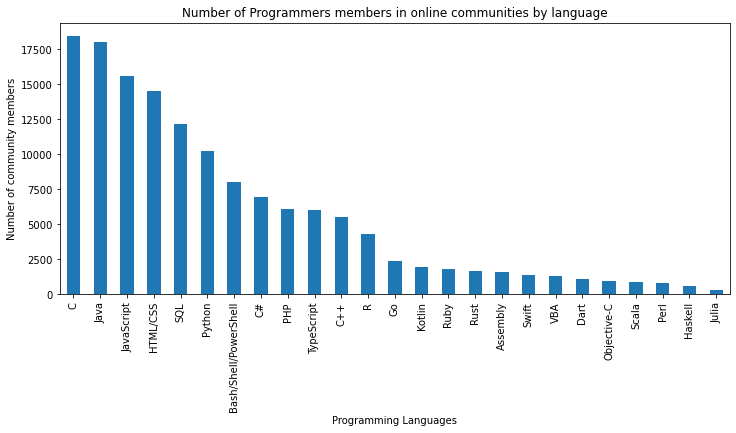

In [15]:
df_amount_community_active.plot.bar(figsize=(12,5), legend=False)
plt.ylabel('Number of community members')
plt.xlabel('Programming Languages')
plt.title('Number of Programmers members in online communities by language');

C and Java have a high community too

Python and Bash are well balanced languages with a relatively big community, high Very Satisfied rate and one of the highest salaries